# Compute and plot Relative Potential Energy Plots (Figure 9)

In [26]:
import xarray as xr
import xroms

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import time

from scipy import signal

import warnings
warnings.filterwarnings('ignore')

In [ ]:
run bichan_utils.py # necessary for PL33 filter

## Load in MPAS-O Data and Compute RPE

In [ ]:
mds = []
mdsg = []
mverts = []
midx = []
mnorm = []
for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')

    ds_mpas['dV'] = (dsg.areaCell * ds_mpas.layerThickness) # Compute dV
    ds_mpas['dens'] = (1027.0 * (1.0 - 1.7e-4*(ds_mpas['temperature']-25.0) + 7.6e-4*(ds_mpas['salinity']-15.0))) # Compute density
    mds.append(ds_mpas)
    mdsg.append(dsg)

    verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
                       dsg.yVertex.values[dsg.verticesOnCell-1]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
    midx.append(idx)
    verts = np.array(verts)[idx]
    mverts.append(verts)

    norm = plt.matplotlib.colors.Normalize(-3, 3)
    mnorm.append(norm)

In [ ]:
# Calculate RPE

dens_bins = np.linspace(1020.0, 1063.0, 1001)
g = 9.8

ictr = 0

for ds in mds:
    rpe = []
    area = mdsg[ictr].areaCell.sum().values
    for tidx in range(len(ds.Time)):
        dz = histogram(ds.dens[tidx, :, :], weights=ds.dV[:, tidx, :], bins=[dens_bins,], block_size=ds.Time.size).compute() / area
        z = np.concatenate(([0,], np.cumsum(dz)))
        rpe.append(np.trapz(g * dens_bins * z, z))
    ds['rpe'] = rpe
    ictr+=1

## Load in ROMS Data and Compute RPE

In [ ]:
rfiles = [
         '/roms_channel/10km/roms_his.nc',
         '/roms_channel/5km/roms_his.nc',
         '/roms_channel/2km/roms_his.nc',
         '/roms_channel/1km/roms_his.nc',
         '/roms_channel/500m/roms_his.nc',
         '/roms_channel/200m/roms_his.nc',
         '/roms_channel/100m/roms_his.nc',
        ]

In [ ]:
# Load in ROMS datasets and compute density, volume, and area of cells

def load_dataset(ncfile):
    ds = xr.open_dataset(ncfile, chunks={'ocean_time': 1})
    ds, _ = xroms.roms_dataset(ds)
    ds['dens'] = 1027.0 * (1.0 - 1.7e-4*(ds['temp']-25.0) + 7.6e-4*(ds['salt']-15.0))
    ds['dV'] = ds.dz / (ds.pn * ds.pm)
    ds['dA'] = (1.0 / (ds.pn * ds.pm)).compute()
    return ds

rds = [load_dataset(ncfile) for ncfile in rfiles]

In [ ]:
# Compute RPE

for ds in rds:
    rpe = []
    area = ds.dA[1:-1, 1:-1].sum().values
    for tidx in range(len(ds.ocean_time)):
        dz = histogram(ds.dens[tidx, :, 1:-1, 1:-1],
                       weights=ds.dV[tidx, :, 1:-1, 1:-1],
                       bins=[dens_bins,],
                       block_size=ds.ocean_time.size).compute() / area
        z = np.concatenate(([0,], np.cumsum(dz)))
        rpe.append(np.trapz(g * dens_bins * z, z))
    ds['rpe'] = rpe


## Plot combined $\frac{dRPE}{dt}$ time series figure
#### These plots can also be made by looping over the associated .npy files in the Zenodo repository

In [ ]:
# Consistent rainbow colormap

rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255

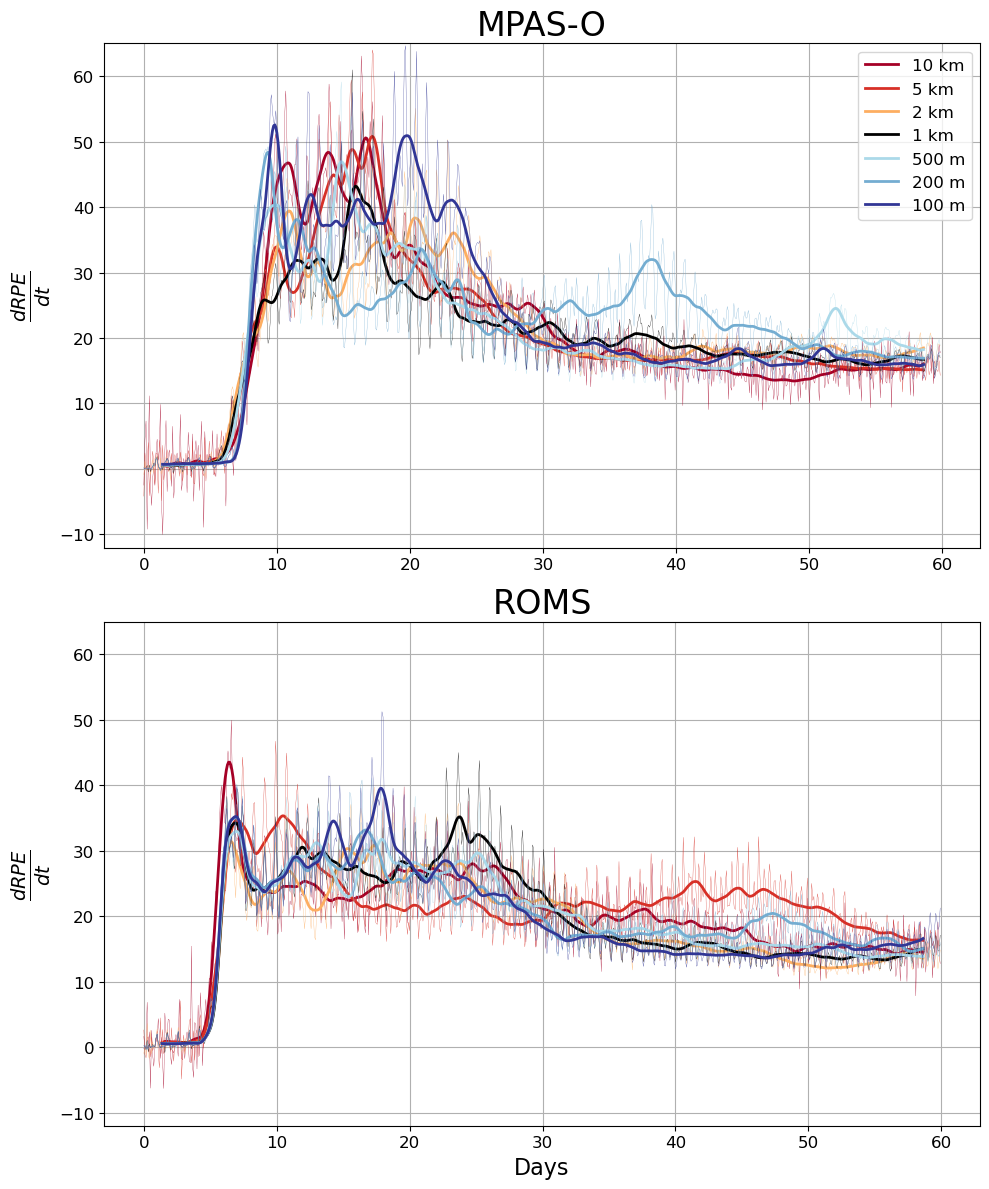

In [25]:
fig = plt.figure(figsize=(10, 12))

res_str = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']


#---------------------------------------------------------------------------------------------#
#----------- MPAS-O -----------#
#---------------------------------------------------------------------------------------------#

ax = fig.add_subplot(211)

pctr = 0
for ds in mds:
    time = ds.Time.values / 12
    grab_rpe = ds.rpe
    rpe_diff = np.diff(grab_rpe[0] - grab_rpe)
    rpe_conv = pl33tn(rpe_diff, dt=2)
    tadjust = (len(time) - len(rpe_conv)) / 24
    ax.plot(time[0:len(rpe_conv)]-time[0]+tadjust, rpe_conv, label=res_str[pctr], linewidth=2, color=rainbow_cmap[pctr,:])
    ax.plot(time[0:len(rpe_diff)]-time[0], rpe_diff, linewidth=0.2, color=rainbow_cmap[pctr,:])
    pctr+=1

ax.grid(True)
ax.set_ylabel(r'$\frac{dRPE}{dt}$', fontsize=20)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('MPAS-O', fontsize=24)
ax.set_ylim([-12, 65])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#---------------------------------------------------------------------------------------------#
#----------- ROMS -----------#
#---------------------------------------------------------------------------------------------#

ax = fig.add_subplot(212)

pctr = 0
for ds in rds:
    time = ds.Time.values / 12
    grab_rpe = ds.rpe
    rpe_diff = np.diff(grab_rpe[0] - grab_rpe)
    rpe_conv = pl33tn(rpe_diff, dt=2)
    tadjust = (len(time) - len(rpe_conv)) / 24
    ax.plot(time[0:len(rpe_conv)]-time[0]+tadjust, rpe_conv, label=res_str[pctr], linewidth=2, color=rainbow_cmap[pctr,:])
    ax.plot(time[0:len(rpe_diff)]-time[0], rpe_diff, linewidth=0.2, color=rainbow_cmap[pctr,:])
    pctr+=1


ax.grid(True)
ax.set_xlabel('Days', fontsize=16)
ax.set_title('ROMS', fontsize=24)
ax.set_ylabel(r'$\frac{dRPE}{dt}$', fontsize=20)
ax.set_ylim([-12, 65])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()